--2025-07-20 05:48:15--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.2’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2025-07-20 05:48:15 (18.9 MB/s) - ‘haarcascade_frontalface_default.xml.2’ saved [930127/930127]

Upload an image for mask detection (JPG/PNG, clear face with/without mask):


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saving 1002.png to 1002 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


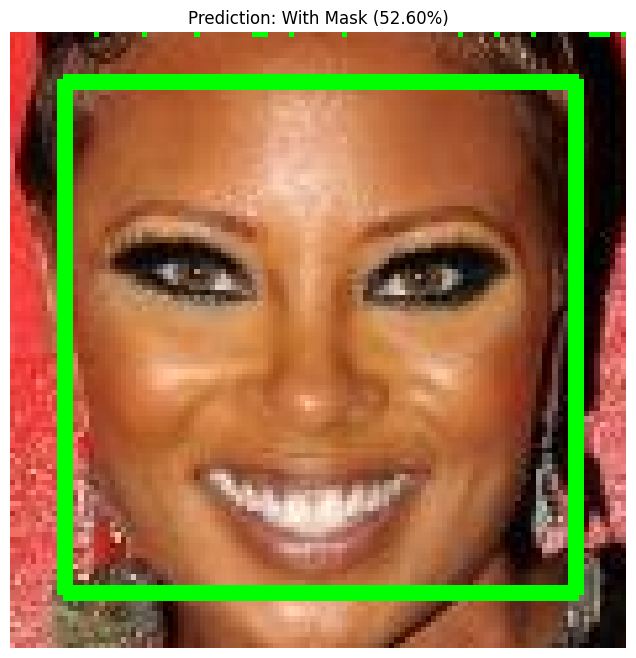

In [3]:
# Face Mask Detection System


!pip install opencv-python-headless tensorflow numpy matplotlib

import cv2
import numpy as np
import tensorflow as tf
from google.colab import files
import io
from PIL import Image
import matplotlib.pyplot as plt

# Step 3: Downloading Haar Cascade for Face Detection
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


def create_mask_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')  # 2 classes: With Mask, Without Mask
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_mask_model()

# Step 5: Defining Image Preprocessing Function
def preprocess_image(image):
    # Convert to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("No faces detected in the image.")

    # Use the first detected face
    (x, y, w, h) = faces[0]
    face_img = image[y:y+h, x:x+w]
    # Resize to 224x224
    face_img = cv2.resize(face_img, (224, 224))
    # Normalize
    face_img = face_img / 255.0
    # Add batch dimension
    face_img = np.expand_dims(face_img, axis=0)
    return face_img, (x, y, w, h)

# Step 6: Upload an Image for Testing
print("Upload an image for mask detection (JPG/PNG, clear face with/without mask):")
uploaded = files.upload()
if not uploaded:
    raise ValueError("No image uploaded. Please upload a JPG or PNG image.")

image_path = list(uploaded.keys())[0]
image = cv2.imdecode(np.frombuffer(uploaded[image_path], np.uint8), cv2.IMREAD_COLOR)
if image is None:
    raise ValueError("Failed to load image. Ensure it's a valid JPG or PNG.")

# Step 7: Preprocess and Predict
try:
    processed_image, (x, y, w, h) = preprocess_image(image)
    prediction = model.predict(processed_image)
    label = "With Mask" if np.argmax(prediction) == 0 else "Without Mask"
    confidence = np.max(prediction) * 100

    # Draw rectangle around face and add label
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, f"{label} ({confidence:.2f}%)", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display result
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error: {str(e)}")

